<a href="https://colab.research.google.com/github/RagnaChris/DeepLearning/blob/master/Notebooks/Image%20Classification/Fashion-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST

Image Classification for Fashion-MNIS

In [1]:
!pip install lightning tensorboard torchmetrics tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
import torch
import torchmetrics

import lightning as L
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import torchvision as tv
import tqdm.auto as tqdm

from torch import nn, optim

In [3]:
def plot_predictions(model, images, labels, classes):
  fig, axes = plt.subplots(2, 5, figsize=(10, 5))
  for i in range(10):
    image = images[i]
    label = labels[i]
    prediction = model(image).argmax()
    probability = model(image).softmax(dim=1)[0][prediction]
    axes[i // 5][i % 5].imshow(image.numpy().transpose(1, 2, 0))
    axes[i // 5][i % 5].set_title(f"Label: {classes[label]}\nPred: {classes[prediction]}\nProb: {probability:.2f}",
                                  fontsize=12, color="green" if label == prediction else "red")
  plt.show()

def dataset_describe(dataset, dl, train, val, test):
    images, labels = next(iter(dl))
    print(f"Train Length: {len(train)}")
    print(f"Val Length: {len(val)}")
    print(f"Test Length: {len(test)}")
    print(f"Image Shape: {images.shape}")
    print(f"Classes Length: {len(dataset.classes)}")
    print(f"Classes: {dataset.classes}")
    plt.imshow(images[0].numpy().transpose(1, 2, 0))

## Dataset

In [4]:
BATCH_SIZE = 128

In [5]:
dataset = tv.datasets.FashionMNIST(".", train=True, download=True, transform=tv.transforms.ToTensor())
train, val = data.random_split(dataset, [0.8, 0.2])
test = tv.datasets.FashionMNIST(".", train=False, download=True, transform=tv.transforms.ToTensor())

train_dl = data.DataLoader(train, batch_size=BATCH_SIZE)
val_dl = data.DataLoader(val, batch_size=BATCH_SIZE)
test_dl = data.DataLoader(test, batch_size=BATCH_SIZE)

100%|██████████| 26421880/26421880 [00:02<00:00, 12421940.37it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210080.34it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3923689.26it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22352253.61it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Train Length: 48000
Val Length: 12000
Test Length: 10000
Image Shape: torch.Size([128, 1, 28, 28])
Classes Length: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


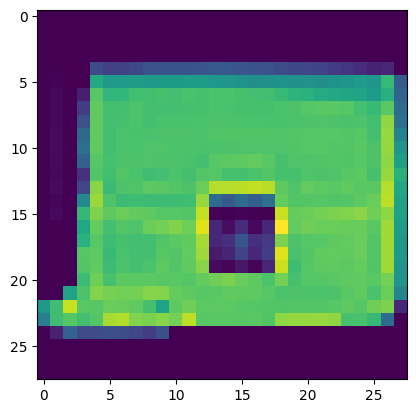

In [6]:
dataset_describe(dataset, train_dl, train, val, test)

## Model

In [21]:
class ConvClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.end_size = 16*24*24
        self.acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc = nn.Linear(self.end_size, 10)
        self.seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.conv2,
            nn.ReLU()
        )

    def forward(self, x):
        x = self.seq(x)
        x = x.view(-1, self.end_size)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("valid_loss", loss, on_step=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.acc(y_hat, y)
        self.log("test_loss", loss, on_step=True, on_epoch=True)
        self.log("test_acc", self.acc, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [22]:
L.seed_everything(42)
model = ConvClassifier()
trainer = L.Trainer(max_epochs=10)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, train_dl, val_dl)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type               | Params
---------------------------------------------
0 | acc   | MulticlassAccuracy | 0     
1 | conv1 | Conv2d             | 80    
2 | conv2 | Conv2d             | 1.2 K 
3 | fc    | Linear             | 92.2 K
4 | seq   | Sequential         | 1.2 K 
---------------------------------------------
93.4 K    Trainable params
0         Non-trainable params
93.4 K    Total params
0.374     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type               | Params
---------------------------------------------
0 | acc   | MulticlassAccuracy | 0     
1 | conv1 | Conv2d             | 80    
2 | conv2 | Conv2d             | 1.2 K 
3 | fc    | Linear             | 92.2 K
4 | seq   | Sequential         | 1.2 K 
---------------------------------------------
93.4 K    Trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [24]:
trainer.test(model, test_dl)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8945000171661377     │
│      test_loss_epoch      │    0.30735287070274353    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.30735287070274353,
  'test_acc_epoch': 0.8945000171661377}]

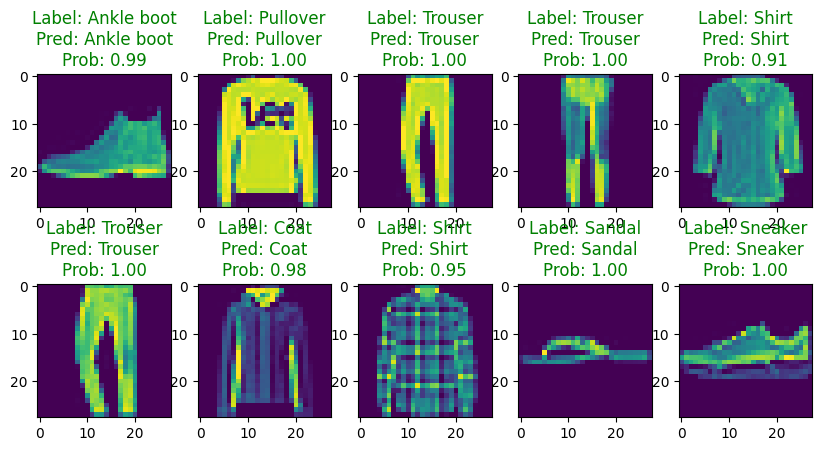

In [25]:
images, labels = next(iter(test_dl))
plot_predictions(model, images, labels, dataset.classes)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./lightning_logs